# Import

In [2]:
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

from kesacco import clustpipe
from kesacco.Tools import mcmc_spectralimaging2 as mc

In [3]:
cpipe = clustpipe.ClusterPipe(silent=False, output_dir='/Users/adam/Project/CTA/Phys/Outputs/KESACCO_Dev')

             _  __  ___    __    __     ___   ___   __         
            | |/ / | __| /' _/  /  \   / _/  / _/  /__\        
            |   <  | _|  `._`. | /\ | | \__ | \__ | \/ |       
            |_|\_\ |___| |___/ |_||_|  \__/  \__/  \__/        
Keen Event Simulation and Analysis for CTA Cluster Observations
---------------------------------------------------------------


In [4]:
# Set the cluster basic properties
cpipe.cluster.name     = 'Perseus'
cpipe.cluster.redshift = 0.017284
cpipe.cluster.M500     = 6.2e14*u.solMass # Used for getting R500 and the pressure profile
cpipe.cluster.coord    = SkyCoord("3h19m47.2s +41d30m47s", frame='icrs')

# Truncate the cluster at 1.5 deg to allow small map field of view (for faster code) without loss of flux
cpipe.cluster.theta_truncation = 1.5*u.deg

# The target gas density [Churazov et al. 2003]
cpipe.cluster.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':57*u.kpc, 'n_01':0.046*u.cm**-3,
                                   'beta2':0.71, 'r_c2':278*u.kpc, 'n_02':0.0036*u.cm**-3}

# The thermal profile (assuming Planck 2013 UPP)
cpipe.cluster.set_pressure_gas_gNFW_param('P13UPP')

# CR physics
cpipe.cluster.X_cre1_E = {'X':0.0, 'R_norm':cpipe.cluster.R500}
cpipe.cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.2}
cpipe.cluster.set_density_crp_isobaric_scal_param(scal=1.0)
cpipe.cluster.X_crp_E = {'X':1.0, 'R_norm':cpipe.cluster.R500}

# Sampling
cpipe.cluster.map_reso = 0.01*u.deg      # Ideally should be few times smaller than the PSF
cpipe.cluster.Npt_per_decade_integ = 30

In [10]:
cpipe.obs_setup.add_obs(obsid='001', name='Perseus_Ptg1', 
                        coord=SkyCoord(cpipe.cluster.coord.ra.value+0, cpipe.cluster.coord.dec.value+1, unit='deg'),
                        rad=5*u.deg,
                        emin=0.05*u.TeV, emax=100*u.TeV,
                        caldb='prod3b-v2', irf='North_z20_S_5h',
                        tmin='2020-01-01T00:00:00.0', tmax='2020-01-01T01:00:00.0', deadc=0.95)

In [15]:
#----- Analysis parameters
cpipe.method_binned = True    # Do a binned analysis
cpipe.method_stack  = True    # Stack the event from different observations in a single analysis?
cpipe.method_ana    = '3D'    # 3D or ONOFF analysis
cpipe.spec_enumbins = 30
cpipe.spec_emin     = 50*u.GeV
cpipe.spec_emax     = 10*u.TeV
cpipe.spec_edisp    = False

# Force the use of the user defined map grid
cpipe.map_UsePtgRef     = True
# Define the map used for the binned analysis
cpipe.map_reso          = 0.05*u.deg # Can be increaded if the code is too slow
cpipe.map_fov           = 3*u.deg    # Can also be reduced (but should increase bkg-cluster degeneracy)
cpipe.map_coord         = copy.deepcopy(cpipe.cluster.coord)
# Define the map used for the template
cpipe.cluster.map_fov   = 2.1*cpipe.cluster.theta_truncation
cpipe.cluster.map_coord = copy.deepcopy(cpipe.cluster.coord)

In [16]:
data, modgrid = mc.read_data([cpipe.output_dir+'/Ana_Countscube.fits',
                              cpipe.output_dir+'/Ana_MCMC_SpecImg2/Grid_Sampling.fits'])

In [17]:
param = [1.0, 1.2, 2.3, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]

In [18]:
model_mcmc = mc.model_specimg(modgrid, param)

In [19]:
rad      = np.logspace(-1,5,10000)*u.kpc
prof_ini = cpipe.cluster._get_generic_profile(rad, cpipe.cluster.density_crp_model)
subdir = '/Users/adam/Desktop/'

mc.build_model_grid(cpipe, subdir, rad, prof_ini,
                     np.array([param[1]]),np.array([0]),
                     np.array([param[2]]),np.array([1]),
                     np.array([param[4]]),np.array([0]),
                     np.array([param[6]]),np.array([0]),
                     includeIC=False,
                     rm_tmp=False)

--- Building cluster template 1/1
    ---> spectral = 2.3, spatial = 1.2
--- Building background template 1/1
    ---> spectral value = 0.0


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [20]:
model_cl_true  = fits.open(subdir+'/Model_Cluster_Cube_TMP_0_0.fits')[0].data
model_bk_true  = fits.open(subdir+'/Model_Background_Cube_TMP_0.fits')[0].data
model_ngc_true = fits.open(subdir+'/Model_NGC1275_Cube_TMP_0.fits')[0].data
model_ic_true  = fits.open(subdir+'/Model_IC310_Cube_TMP_0.fits')[0].data

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


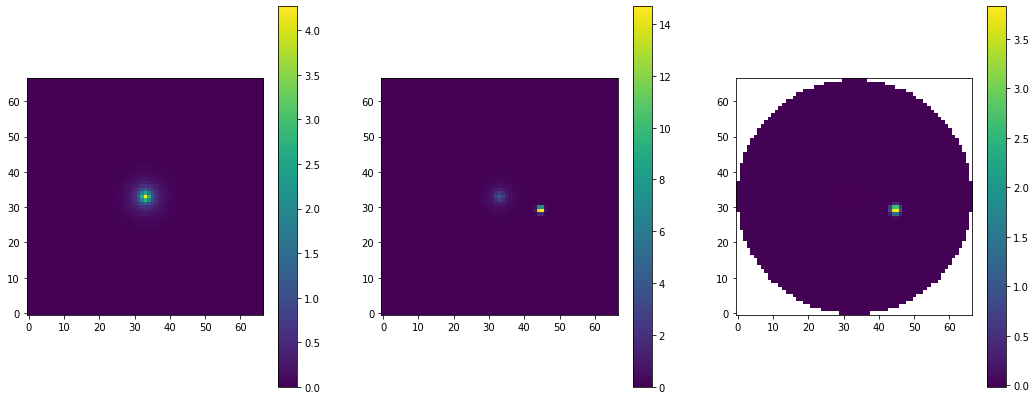

In [21]:
ibin = 20
fig = plt.figure(0, figsize=(18, 7))
ax = plt.subplot(131)
plt.imshow(model_mcmc['cluster'][ibin,:,:], origin='lower')
plt.colorbar()
ax = plt.subplot(132)
plt.imshow(model_cl_true[ibin,:,:], origin='lower')
plt.colorbar()
ax = plt.subplot(133)
plt.imshow((model_cl_true[ibin,:,:]-model_mcmc['cluster'][ibin,:,:])/model_cl_true[ibin,:,:]**0.5, origin='lower')
plt.colorbar()